# Retrosynthetic Planning Using Quantum Reinforcement Learning

In this notebook, we demonstrate how to solve the problem of retrosynthetic planning using quantum reinforcement learning. This problem can be modeled as a one-player game. The chemist works backwards from a molecular target to simpler materials. The choice should come from the reliable reactions between materials [1].

![retro-plan](./images/retro-plan.png)

This problem can be challenging since there may be tens of thousands of combinations. In addition, the value of
each choice remains uncertain until the whole synthesis plan is completed. Some researchers tried to solve this problem using deep reinforcement learning. They modeled the problem this way:

![model-retro](./images/model-retro.png)

Chemical modelcules are illustrated as circles where different color represents different type of molecules.
Orange circle represents the molecular target. The reactions need to be found so that the chemist can start 
from commercially available substrate which are red circles there. Then, after some reactions and intermediate molecules, the molecular target can be synthesized. Reactions are squares in this graph. For example, with substrates $m_9$ and $m_{10}$, the intermediate $ m_4 $ and be synthesized through reaction $ r_3 $.

However, there are some rules to follow in this scenario:

* The synthesis cost should be minimized. According to the following cost equation, the cost $ c_{tot} $
equals the cost of chosen reactions, $ c_{rxn}(r) $, plus the cost of chosen intermediate molecules 
and substrate molecules, $ c_{sub}(m) $. The number inside circles or squares is cost. In this example, the
target molecule $ m_0 $ is synthesized at the cost of 5 because of reaction $ r_0 $, intermediate molecules $ m_1 $ and $ m_3 $. The cost of $ m_2 $ comes from the sum of
 reaction $ r_1 $ and intermediate molecule $ m_4 $.

<center>

$ c_{tot} = \sum \limits _{r} c_{rxn}(r) + \sum \limits _{m} c_{sub}(m) $

</center>

* All commercially available substrates are assigned zero cost.
* If the molecules without possible reactions are reached, a cost penalty of 100 is assigned. These 
dead-end molecule are represented as red circles there. 
* The reaction steps are represented as depth $ d $ there. If a molecule with maximum depth is reached, a cost penalty of 10 is assigned. In this example, the molecule with $ d_{max} = 10 $ is represented as purple circl.

All the above modeling method comes from [2], these parameters can be adjusted according to actual application.
The core part in [2] is a multilayer neural network illustrated schematically in the following image. In this 
notebook we will show how to use quantum neural network with fewer parameters to achieve the similar results in an open source dataset.

![cc-nn](./images/cc-nn.png)


[1] Wiki [Retrosynthetic analysis](https://en.wikipedia.org/wiki/Retrosynthetic_analysis).

[2] [Schreck, John S., Connor W. Coley, and Kyle JM Bishop. "Learning retrosynthetic planning through simulated experience." ACS central science 5.6 (2019): 970-981.](https://pubs.acs.org/doi/10.1021/acscentsci.9b00055).

### Data preparation

USPTO (United States Patent and Trademark Office) 50K consists of 50K extracted atom-mapped reactions with 10 reaction types.
The dataset [USPTO-50K](https://tdcommons.ai/generation_tasks/retrosyn/#uspto-50k) is used in this experiment. The whole dataset is put together and used for plannning task.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Load the uspto-50k data
from tdc.generation import RetroSyn
from tdc.utils.retrieve import get_reaction_type

data = RetroSyn(name = 'USPTO-50K')
split = data.get_split()

Found local copy...
Loading...
Done!


In [3]:
# Let's explore how this data looks like
split['train'].head(2)

,input,output
0,COC(=O)CCC(=O)c1ccc(OC2CCCCO2)cc1O,C1=COCCC1.COC(=O)CCC(=O)c1ccc(O)cc1O
1,COC(=O)c1cccc(-c2nc3cccnc3[nH]2)c1,COC(=O)c1cccc(C(=O)O)c1.Nc1cccnc1N


In [ ]:
df = data.get_data(format="df")
rt = get_reaction_type(data.name)
df["category"] = rt
df.columns = ['product','reactant', 'category']
df[['reactant', 'product','category']] = df[['product','reactant', 'category']]
df.columns = ['reactant', 'product','category']
raw_path = './data/uspto50k.xlsx'
df.to_excel(raw_path, index=False)

The data only contains input and output columns since this is for prediction task. We decide to put all these 
data together to make something like target, intermediate, substrate and dead-end molecules.

<div class="alert alert-block alert-warning">
<b>Run time warning:</b> The following block may run more than half an hour. If you didn't want to prepare data from scratch, please
    uncomment the next code block and use data directly
</div>

In [ ]:
from braket.experimental.algorithms.qc_qrl.utility.DataPrepare import Prepare

prepare = Prepare(raw_path)
prepare.generate_files()  # 
prepare.generate_ground_truth()
ground_truth = np.load(prepare.path+'ground_truth.npy', allow_pickle=True).tolist()

data_path = 'data'
!cp buyable.npy $data_path
!cp deadend.npy $data_path
!cp reactions_dictionary.npy $data_path
!cp smiles_dictionary.npy $data_path
!cp target_product.npy $data_path
!cp ground_truth.npy $data_path

In [4]:
# # uncomment the following code if you don't want re-process all the data
# data_path = 'data'
# # download dateset
# !mkdir $data_path
# !mkdir $data_path\smiles
# !wget https://d1o8djwwk7diqy.cloudfront.net/retrosynthetic-plannin-dataset.zip
# !unzip -o retrosynthetic-plannin-dataset.zip

# # linux
# !cp -r retrosynthetic-planning-dataset/* $data_path
# !cp data/smiles_map.npy  data/smiles
# !rm retrosynthetic-plannin-dataset.zip 

mkdir: cannot create directory ‘data’: File exists
mkdir: cannot create directory ‘datasmiles’: File exists
--2024-01-12 14:16:29--  https://d1o8djwwk7diqy.cloudfront.net/retrosynthetic-plannin-dataset.zip
Resolving d1o8djwwk7diqy.cloudfront.net (d1o8djwwk7diqy.cloudfront.net)... 99.84.71.124, 99.84.71.146, 99.84.71.174, ...
Connecting to d1o8djwwk7diqy.cloudfront.net (d1o8djwwk7diqy.cloudfront.net)|99.84.71.124|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3841896 (3.7M) [application/zip]
Saving to: ‘retrosynthetic-plannin-dataset.zip’

retrosynthetic-plan 100%[===================>]   3.66M  --.-KB/s    in 0.1s    

2024-01-12 14:16:29 (25.0 MB/s) - ‘retrosynthetic-plannin-dataset.zip’ saved [3841896/3841896]

Archive:  retrosynthetic-plannin-dataset.zip
  inflating: retrosynthetic-planning-dataset/buyable.npy  
  inflating: retrosynthetic-planning-dataset/target_product.npy  
  inflating: retrosynthetic-planning-dataset/reactions_dictionary.npy  
  inflati

## Prepare parameters for classical and quantum experiments

In [6]:
!pip install -r requirement.txt

In [7]:
from braket.experimental.algorithms.qc_qrl.utility.RetroRLAgent import RetroRLAgent

In [8]:
# set up .env files to access your s3 bucket, you can put your environment variables in a local .env file
from dotenv import load_dotenv
import os
load_dotenv()
# please change the following s3 bucket to the one you can upload and download data
s3_bucket_name = os.environ.get('AWS_S3_BUCKET_NAME', '')

In [9]:
agent_param = {}
# initial the RetroRLModel object
init_param = {}
method = ['retro-rl', 'retro-qrl']

for mt in method:
    if mt == 'retro-rl':
        init_param[mt] = {}
        init_param[mt]['param'] = ['inputsize', 'middlesize', 'outputsize']
    elif mt == 'retro-qrl':
        init_param[mt] = {}
        init_param[mt]['param'] = ['n_qubits', 'device', 'framework', 'shots', 'layers']
    
# retro_rl_model = RetroRLModel(data=None, method=method, **init_param)
agent_param['init_param'] = init_param

In [10]:
# train_mode can be: "local-instance", "local-job", "hybrid-job"
train_mode = "hybrid-job"

data_path = 'data'
s3_data_path = None
if train_mode == "local-job" or train_mode == "hybrid-job":
    s3_data_path = f"{s3_bucket_name}/data"
    import os
    os.system(f"aws s3 sync {data_path} {s3_data_path}")

agent_param["data_path"] = data_path
agent_param["s3_data_path"]=s3_data_path
agent_param["train_mode"] = train_mode
agent_param["episodes"] = 300
agent_param["epoches_per_episode"] = 50

upload: data/Deadend.npy to s3://amazon-braket-us-west-2-002224604296/data/Deadend.npy
upload: data/smiles_map.npy to s3://amazon-braket-us-west-2-002224604296/data/smiles_map.npy
upload: data/smiles to s3://amazon-braket-us-west-2-002224604296/data/smiles
upload: data/reactions_dictionary.npy to s3://amazon-braket-us-west-2-002224604296/data/reactions_dictionary.npy
upload: data/buyable.npy to s3://amazon-braket-us-west-2-002224604296/data/buyable.npy
upload: data/target_product.npy to s3://amazon-braket-us-west-2-002224604296/data/target_product.npy
upload: data/uspto50k.xlsx to s3://amazon-braket-us-west-2-002224604296/data/uspto50k.xlsx
upload: data/ground_truth.npy to s3://amazon-braket-us-west-2-002224604296/data/ground_truth.npy
upload: data/smiles_dictionary.npy to s3://amazon-braket-us-west-2-002224604296/data/smiles_dictionary.npy


In [11]:
import json
 
agent_param_format = json.dumps(agent_param, indent=4)
print("The agent parameters : \n", agent_param_format)

The agent parameters : 
 {
    "init_param": {
        "retro-rl": {
            "param": [
                "inputsize",
                "middlesize",
                "outputsize"
            ]
        },
        "retro-qrl": {
            "param": [
                "n_qubits",
                "device",
                "framework",
                "shots",
                "layers"
            ]
        }
    },
    "data_path": "data",
    "s3_data_path": "s3://amazon-braket-us-west-2-002224604296/data",
    "train_mode": "hybrid-job",
    "episodes": 300,
    "epoches_per_episode": 50
}


### Compare quatum circuit and classical circuit

First, we use the local instance to see how the classical and quantum model are different

In [12]:
model_param={}
method = 'retro-qrl'
model_param[method] = {}
model_param[method]['n_qubits'] = [8]
# model_param[method]['device'] = ['local', 'sv1', 'aspen-m-3', 'aria-2']
model_param[method]['device'] = ['local']
model_param[method]['framework'] = ['pennylane']
model_param[method]['shots'] = [100]
model_param[method]['layers'] = [1]

agent_param['model_param'] = model_param

n_qubits = model_param[method]['n_qubits'][0]
device = model_param[method]['device'][0]
framework = model_param[method]['framework'][0]
shots = model_param[method]['shots'][0]
layers = model_param[method]['layers'][0]

model_name = "{}_{}_{}_{}_{}".format(n_qubits, device, framework, shots, layers)
agent_param["model_name"] = model_name

agent_param["train_mode"]="local-instance"

if agent_param["train_mode"] == "local-instance":
    retro_qrl_agent = RetroRLAgent(build_model=True, method=method, **agent_param)
else:
    retro_qrl_agent = RetroRLAgent(build_model=False, method=method, **agent_param)

INFO:root:initial reinforcement learning for retrosynthetic-planning
INFO:root:initial quantum reinforcement learning for retrosynthetic-planning
INFO:root:initial a new agent...
INFO:root:load data...
INFO:root:build_model is True
INFO:root:model_param is {'retro-qrl': {'n_qubits': [8], 'device': ['local'], 'framework': ['pennylane'], 'shots': [100], 'layers': [1]}}
INFO:root:Construct model for n_qubits:8,device:local,framework:pennylane,layers:1 0.0007879098256429036 min


<div class="alert alert-block alert-warning">
<b>Run time warning:</b> The following block may run more than one hour if you use CPU instance. However, if you GPU instance, like g5 instance or A10 GPU, it will take less than 10 minutes.
</div>

In [13]:
# let's run reinforcement learning
retro_qrl_agent.game_job()

INFO:root:episode 1
INFO:root:epsiode 1 averate cost 121.42704280155642 start training for 50 epoches...
INFO:root:episode 2
INFO:root:epsiode 2 averate cost 121.30120176718547 start training for 50 epoches...
INFO:root:episode 3
INFO:root:epsiode 3 averate cost 121.3348228761349 start training for 50 epoches...
INFO:root:episode 4
INFO:root:epsiode 4 averate cost 121.29877709838766 start training for 50 epoches...
INFO:root:episode 5
INFO:root:epsiode 5 averate cost 121.25109435797665 start training for 50 epoches...
INFO:root:episode 6
INFO:root:epsiode 6 averate cost 121.28953874837873 start training for 50 epoches...
INFO:root:episode 7
INFO:root:epsiode 7 averate cost 121.44404298684422 start training for 50 epoches...
INFO:root:episode 8
INFO:root:epsiode 8 averate cost 121.33509357050181 start training for 50 epoches...
INFO:root:episode 9
INFO:root:epsiode 9 averate cost 121.43236983509324 start training for 50 epoches...
INFO:root:episode 10
INFO:root:epsiode 10 averate cost 1

In [14]:
model_param={}
method = 'retro-rl'
model_param[method] = {}
model_param[method]['inputsize'] = [256]
model_param[method]['middlesize'] = [256]
model_param[method]['outputsize'] = [1]

agent_param['model_param'] = model_param
model_name = f"{model_param[method]['inputsize'][0]}_{model_param[method]['middlesize'][0]}_{model_param[method]['outputsize'][0]}"
agent_param["model_name"] = model_name

agent_param["train_mode"]="local-instance"

if agent_param["train_mode"] == "local-instance":
    retro_crl_agent = RetroRLAgent(build_model=True, method=method, **agent_param)
else:
    retro_crl_agent = RetroRLAgent(build_model=False, method=method, **agent_param)

INFO:root:initial reinforcement learning for retrosynthetic-planning
INFO:root:initial quantum reinforcement learning for retrosynthetic-planning
INFO:root:initial a new agent...
INFO:root:load data...
INFO:root:build_model is True
INFO:root:model_param is {'retro-rl': {'inputsize': [256], 'middlesize': [256], 'outputsize': [1]}}
INFO:root:Construct model for inputsize:256,middlesize:256,outputsize:1 1.4352798461914063e-05 min


In [15]:
# let's run reinforcement learning
retro_crl_agent.game_job()

INFO:root:episode 1
INFO:root:epsiode 1 averate cost 120.56063553826199 start training for 50 epoches...
INFO:root:episode 2
INFO:root:epsiode 2 averate cost 120.48199375810636 start training for 50 epoches...
INFO:root:episode 3
INFO:root:epsiode 3 averate cost 120.48925328886409 start training for 50 epoches...
INFO:root:episode 4
INFO:root:epsiode 4 averate cost 120.50714372568093 start training for 50 epoches...
INFO:root:episode 5
INFO:root:epsiode 5 averate cost 120.58652955345553 start training for 50 epoches...
INFO:root:episode 6
INFO:root:epsiode 6 averate cost 120.58639348249027 start training for 50 epoches...
INFO:root:episode 7
INFO:root:epsiode 7 averate cost 120.74930516953854 start training for 50 epoches...
INFO:root:episode 8
INFO:root:epsiode 8 averate cost 120.61895497498601 start training for 50 epoches...
INFO:root:episode 9
INFO:root:epsiode 9 averate cost 120.52418733787289 start training for 50 epoches...
INFO:root:episode 10
INFO:root:epsiode 10 averate cost 

### Compare results in terms of number of parameters and cost

We can compare the number of parameters of classical circuit and the loss curve. It can be shown that although the number of quantum 
circuit is very small, it can still decrease the cost value

In [16]:
# let's see how many parameters are in quantum circuit model
quantum_param_sum = 0
for param in retro_qrl_agent.NN.parameters():
    quantum_param_sum = quantum_param_sum + param.numel()
# let's see how many parameters are in classical circuit model
classical_param_sum = 0
for param in retro_crl_agent.NN.parameters():
    classical_param_sum = classical_param_sum + param.numel()

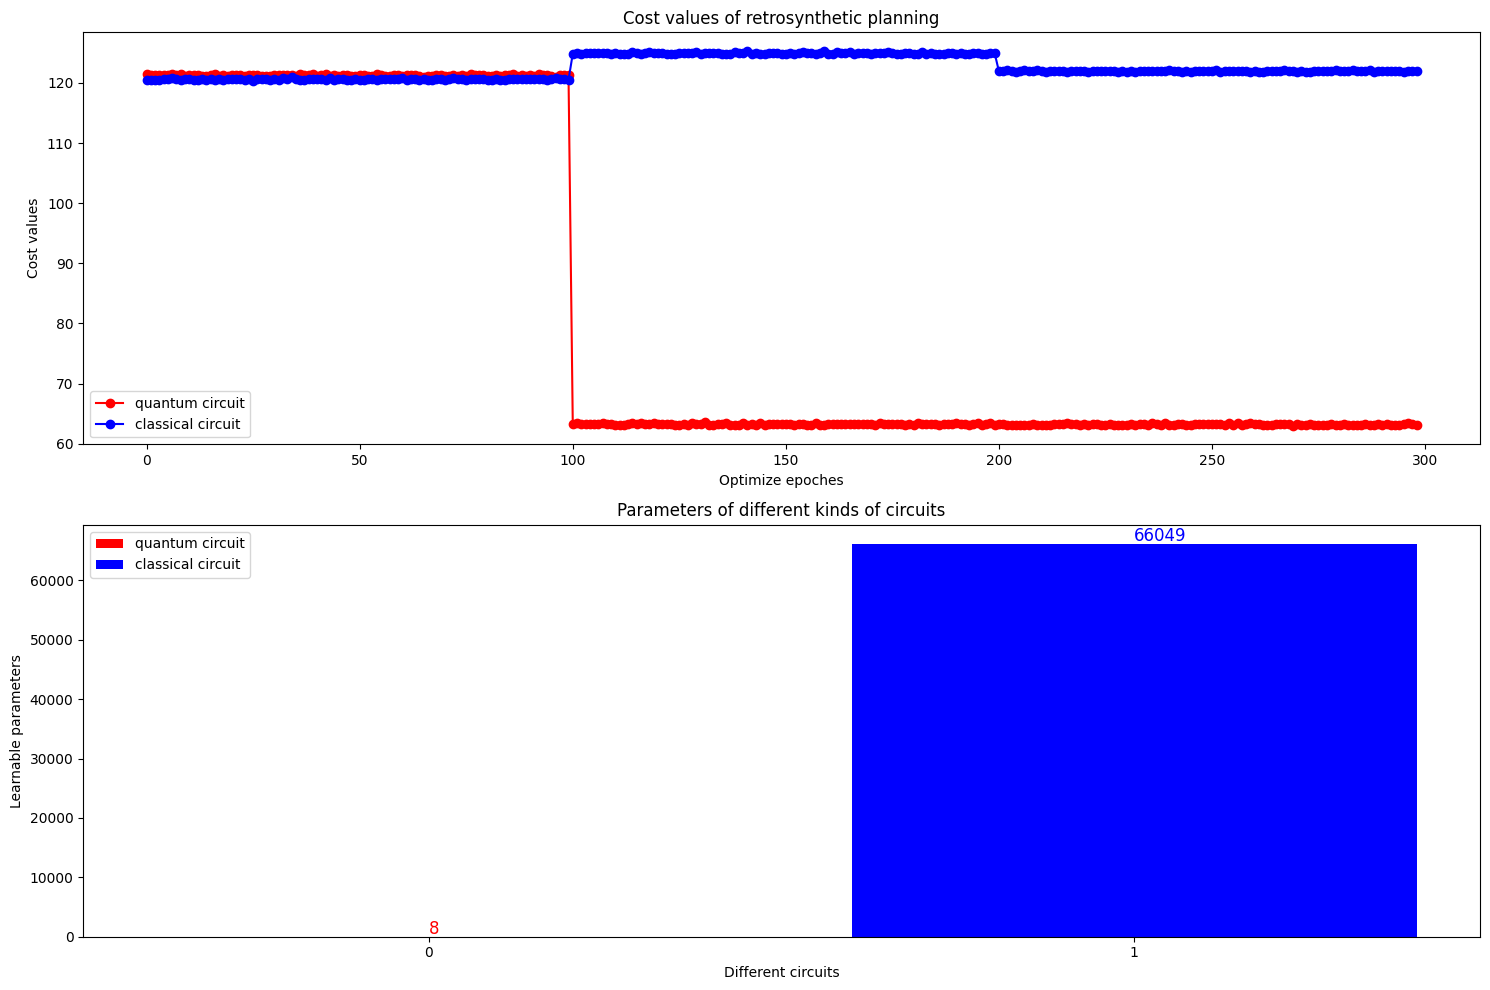

In [17]:
import matplotlib.pyplot as plt

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

def draw_cost_curve_and_circuit_parameters(cost_infos, circuit_infos):
    # Line graph subplot
    # plt.subplot(2, 1, 1)
    f, (ax1, ax2) = plt.subplots(2, figsize=(15, 10))
    for cost in cost_infos:
        cost_value = cost['value']
        x_line = range(len(cost_value))
        cost_color = cost['color']
        cost_title = cost['title']
        ax1.plot(x_line, cost_value, marker='o', linestyle='-', color=cost_color, label=cost_title)
    
    ax1.set_xlabel('Optimize epoches')
    ax1.set_ylabel('Cost values')
    ax1.set_title('Cost values of retrosynthetic planning')
    ax1.legend()

    # # Bar graph subplot
    # plt.subplot(2, 1, 2)
    circuit_parameters = circuit_infos['parameters']
    x_bar = range(len(circuit_parameters))
    colors = circuit_infos['colors']
    titles = circuit_infos['titles']
    ax2.bar(x_bar, circuit_parameters, color=colors, label=titles)
    idx = 0
    for param, color in zip(circuit_parameters, colors):
        ax2.text(idx, param + 500, str(param), color=color, fontsize = 12)
        idx = idx + 1
    ax2.set_xticks(x_bar)
    ax2.set_xlabel('Different circuits')
    ax2.set_ylabel('Learnable parameters')
    ax2.set_title('Parameters of different kinds of circuits')
    ax2.legend()

    
    # plt.legend()
    plt.tight_layout() 
    plt.show()

cost_infos = []
cost_infos.append({'value':retro_qrl_agent.avtocost, 'color':'red', 'title':"quantum circuit"})
cost_infos.append({'value':retro_crl_agent.avtocost, 'color':'blue', 'title':"classical circuit"})
circuit_infos = {}
circuit_infos['parameters'] = [quantum_param_sum, classical_param_sum]
circuit_infos['titles'] = ["quantum circuit", "classical circuit"]
circuit_infos['colors'] = ["red", "blue"]

draw_cost_curve_and_circuit_parameters(cost_infos, circuit_infos)

Before analyzing these two pictures, we need to clarify several concepts：
1. The cost value means the cost to complete a synthesis. Please refer to the introduction to synthesis cost at the beginning.
2. The optimize epoches means the times you optimize the parameters on the whole dataset. It equals to episodes times epoches_per_episode
3. The parameters in the second picture mean the number of learnable parameters in classical or quantum circuit.

From the above figure, we can observe an interesting phenomenon. Under the current application and a corresponding open source data set, Although a quantum circuit has fewer learnable parameters, it can reduce the synthesis cost to a lower stable value faster, from 120 to 60. This encourages us to explore in this direction on larger data sets.